<a href="https://colab.research.google.com/github/sujitpal/deeplearning-ai-examples/blob/master/tricks02_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## More tricks to improve CIFAR-10 classifier

Some more tricks that I came across in subsequent classes of the [Deep Learning with Pytorch](https://www.youtube.com/playlist?list=PLLHTzKZzVU9eaEyErdV26ikyolxOsz6mq) course from New York University, as listed below.

1. Wider network.
1. Deeper network.
1. Batch Norm.
1. Residual Connection.
1. Gradient Clipping.
1. Increase batch size.

Unlike the previous notebook, these are not listed neatly in a single slide, but are mentioned in passing. 

As with the previous notebook, we start with a baseline CNN with 3 layers, ReLU activation and Adam optimizer.


Residual: https://medium.com/analytics-vidhya/understanding-and-implementation-of-residual-networks-resnets-b80f9a507b9c


In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import shutil

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support
from torchsummary import summary

%matplotlib inline

In [2]:
TRAIN_IMAGES_DIR = "cifar10-train"
TEST_IMAGES_DIR = "cifar10-test"
MODEL_DIR = "models"

shutil.rmtree(MODEL_DIR, ignore_errors=True)
os.mkdir(MODEL_DIR)

In [3]:
CIFAR10_LABELS = [
  "aircraft", "automobile", "bird", "cat", "deer", 
  "dog", "frog", "horse", "ship", "truck"
]
idx2label = {i:x for i, x in enumerate(CIFAR10_LABELS)}
label2idx = {v:k for k, v in idx2label.items()}

len(idx2label), len(label2idx)

(10, 10)

### Baseline

* Data from `torchvision.datasets.CIFAR10`
* Model based on [Tensorflow CNN tutorial](https://www.tensorflow.org/tutorials/images/cnn)
    * 3 layer convolution/pool layers
    * 2 layer dense head
    * Adam optimizer

In [4]:
train_ds = torchvision.datasets.CIFAR10(TRAIN_IMAGES_DIR,
                                        transform=torchvision.transforms.Compose([
                                          torchvision.transforms.ToTensor()                      
                                        ]),
                                        train=True, download=True)
test_ds = torchvision.datasets.CIFAR10(TEST_IMAGES_DIR, 
                                       transform=torchvision.transforms.Compose([
                                          torchvision.transforms.ToTensor()                      
                                       ]),
                                       train=False, download=True)


Extracting cifar10-train/cifar-10-python.tar.gz to cifar10-train



Extracting cifar10-test/cifar-10-python.tar.gz to cifar10-test


In [5]:
BATCH_SIZE = 64

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

len(train_dl), len(test_dl)

(782, 157)

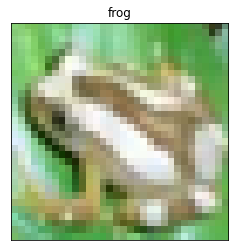

In [6]:
def show_data(image_label):
  image, label = image_label
  image = torch.transpose(torch.transpose(image, 0, 1), 1, 2)
  plt.title(idx2label[label])
  plt.xticks([])
  plt.yticks([])
  _ = plt.imshow(image)

show_data(train_ds[np.random.randint(low=0, high=len(train_dl))])

In [7]:
class Cifar10Classifier(nn.Module):
  def __init__(self, conv_block_sizes, ff_block_sizes,
               spatial_dropout=0, dense_dropout=0,
               input_channels=3, input_size=(32, 32), output_size=10):
    super(Cifar10Classifier, self).__init__()
    # convolution layers
    conv_layers = []
    for cid in range(len(conv_block_sizes)):
      conv_layers.append(nn.Sequential(
        nn.Conv2d(input_channels if cid == 0 else conv_block_sizes[cid - 1],
                  conv_block_sizes[cid], 
                  kernel_size=(3, 3), padding=(1, 1)),
        nn.ReLU(),
        nn.Dropout2d(p=spatial_dropout),
        nn.MaxPool2d(kernel_size=(2, 2))))
    self.conv_blocks = nn.ModuleList(conv_layers)
    # flatten
    self.flatten = nn.Flatten()
    # compute image size to figure out input size after flatten
    conv_output_width = input_size[0] // (2 ** len(conv_block_sizes))
    if conv_output_width < 1:
      raise ValueError("CNN pooling results in less than (1, 1) dimensions, reduce depth")
    conv_size = conv_output_width * conv_output_width * conv_block_sizes[cid]
    # linear layers
    linear_layers = []
    for fid in range(len(ff_block_sizes) + 1):
      linear_layers.append(nn.Sequential(
          nn.Linear(conv_size if fid == 0 else ff_block_sizes[fid - 1],
                    output_size if fid == len(ff_block_sizes) else ff_block_sizes[fid]),
          nn.Dropout(p=dense_dropout),
          nn.ReLU() if fid < len(ff_block_sizes) else nn.LogSoftmax(dim=1)
      ))
    self.linear_blocks = nn.ModuleList(linear_layers)

  def forward(self, x):
    for conv_block in self.conv_blocks:
      x = conv_block(x)
    x = self.flatten(x)
    for linear_block in self.linear_blocks:
      x = linear_block(x)
    return x


model_0 = Cifar10Classifier(
    conv_block_sizes=[32, 64, 64], 
    ff_block_sizes=[64])
summary(model_0, (3, 32, 32), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
         Dropout2d-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
              ReLU-6           [-1, 64, 16, 16]               0
         Dropout2d-7           [-1, 64, 16, 16]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Conv2d-9             [-1, 64, 8, 8]          36,928
             ReLU-10             [-1, 64, 8, 8]               0
        Dropout2d-11             [-1, 64, 8, 8]               0
        MaxPool2d-12             [-1, 64, 4, 4]               0
          Flatten-13                 [-1, 1024]               0
           Linear-14                   

In [8]:
# self-test
x = torch.rand(10, 3, 32, 32)
y = model_0(x)
y.size()

torch.Size([10, 10])

In [9]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_0 = model_0.to(dev)

#### Training

In [10]:
NUM_EPOCHS = 10
LEARNING_RATE = 1e-3

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=LEARNING_RATE)

In [11]:
def train(model, train_dl, loss_fn, optimizer):
  model.train()
  train_losses, train_accs = [], []
  for batch in train_dl:
    images, labels = batch
    
    images = images.to(dev)
    labels = labels.to(dev)

    logits = model(images)
    loss = loss_fn(logits, labels)
    
    train_losses.append(loss.item())
    preds = torch.argmax(logits, dim=1).cpu().numpy()
    labels = labels.cpu().numpy()
    train_accs.append(accuracy_score(preds, labels))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # if len(train_losses) > 5:
    #   break
  
  train_loss = sum(train_losses) / len(train_losses)
  train_acc = sum(train_accs) / len(train_accs)
  return train_loss, train_acc


# # self-test
# train_loss, train_acc = train(model_0, train_dl, loss_fn, optimizer)
# train_loss, train_acc

In [12]:
def validate(model, val_dl, loss_fn):
  model.eval()
  val_losses, val_accs = [], []
  for batch in val_dl:
    images, labels = batch

    images = images.to(dev)
    labels = labels.to(dev)

    with torch.no_grad():
      logits = model(images)
      loss = loss_fn(logits, labels)

    val_losses.append(loss.item())
    preds = torch.argmax(logits, dim=1).cpu().numpy()
    labels = labels.cpu().numpy()
    val_accs.append(accuracy_score(preds, labels))

    # if len(val_losses) > 5:
    #   break

  val_loss = sum(val_losses) / len(val_losses)
  val_acc = sum(val_accs) / len(val_accs)
  return val_loss, val_acc


# # self-test
# val_loss, val_acc = validate(model_0, test_dl, loss_fn)
# val_loss, val_acc

In [13]:
train_losses, train_accs, val_losses, val_accs = [], [], [], []
for epoch in range(1, NUM_EPOCHS + 1):
  train_loss, train_acc = train(model_0, train_dl, loss_fn, optimizer)
  val_loss, val_acc = validate(model_0, test_dl, loss_fn)
  print("Epoch {:2d} | Train Loss: {:.3f}, Accuracy: {:.3f} | Validation Loss: {:.3f}, Accuracy: {:.3f}".format(
      epoch, train_loss, train_acc, val_loss, val_acc))
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  val_losses.append(val_loss)
  val_accs.append(val_acc)

Epoch  1 | Train Loss: 1.650, Accuracy: 0.394 | Validation Loss: 1.365, Accuracy: 0.502
Epoch  2 | Train Loss: 1.272, Accuracy: 0.543 | Validation Loss: 1.162, Accuracy: 0.589
Epoch  3 | Train Loss: 1.104, Accuracy: 0.609 | Validation Loss: 1.035, Accuracy: 0.632
Epoch  4 | Train Loss: 0.988, Accuracy: 0.650 | Validation Loss: 0.977, Accuracy: 0.657
Epoch  5 | Train Loss: 0.899, Accuracy: 0.683 | Validation Loss: 0.963, Accuracy: 0.661
Epoch  6 | Train Loss: 0.834, Accuracy: 0.706 | Validation Loss: 0.881, Accuracy: 0.695
Epoch  7 | Train Loss: 0.781, Accuracy: 0.726 | Validation Loss: 0.850, Accuracy: 0.706
Epoch  8 | Train Loss: 0.736, Accuracy: 0.742 | Validation Loss: 0.869, Accuracy: 0.701
Epoch  9 | Train Loss: 0.691, Accuracy: 0.759 | Validation Loss: 0.820, Accuracy: 0.720
Epoch 10 | Train Loss: 0.651, Accuracy: 0.771 | Validation Loss: 0.860, Accuracy: 0.705


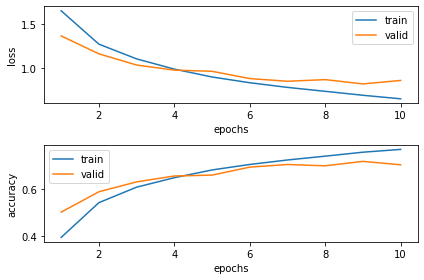

In [14]:
def plot_training_curves(train_losses, train_accs, val_losses, val_accs):
  plt.subplot(2, 1, 1)
  plt.plot(np.arange(NUM_EPOCHS)+1, train_losses, label="train")
  plt.plot(np.arange(NUM_EPOCHS)+1, val_losses, label="valid")
  plt.xlabel("epochs")
  plt.ylabel("loss")
  plt.legend(loc="best")

  plt.subplot(2, 1, 2)
  plt.plot(np.arange(NUM_EPOCHS)+1, train_accs, label="train")
  plt.plot(np.arange(NUM_EPOCHS)+1, val_accs, label="valid")
  plt.xlabel("epochs")
  plt.ylabel("accuracy")
  plt.legend(loc="best")

  plt.tight_layout()
  _ = plt.plot()


plot_training_curves(train_losses, train_accs, val_losses, val_accs)

#### Evaluation

In [15]:
def evaluate(model, test_dl):
  model.eval()
  true_values, pred_values = [], []
  for batch in test_dl:
    images, labels = batch
    images = images.to(dev)

    with torch.no_grad():
      logits = model(images)
    preds = torch.argmax(logits, dim=1).cpu().numpy()
    labels = labels.numpy()

    true_values.extend(labels.tolist())
    pred_values.extend(preds.tolist())

  return true_values, pred_values


true_values, pred_values = evaluate(model_0, test_dl)

In [16]:
print("** accuracy: {:.3f}".format(accuracy_score(true_values, pred_values)))
print("--")
print("confusion matrix")
print(confusion_matrix(true_values, pred_values))
print("--")
print("classification report")
print(classification_report(true_values, pred_values, target_names=CIFAR10_LABELS))

** accuracy: 0.705
--
confusion matrix
[[757   8  64  23  13   2  15   9  84  25]
 [ 23 779  14  11   2   3  12   3  68  85]
 [ 57   5 718  64  57  16  38  22  14   9]
 [ 23   3 146 624  37  55  47  28  24  13]
 [ 19   1 167  73 629   9  38  48  13   3]
 [ 19   3 132 341  43 400  13  32   9   8]
 [  3   4  97  85  33   4 757   4   9   4]
 [ 19   1  95  71  76  23   2 695   3  15]
 [ 43  15  21  14   1   2   4   3 883  14]
 [ 36  52  16  30   3   1   5  11  43 803]]
--
classification report
              precision    recall  f1-score   support

    aircraft       0.76      0.76      0.76      1000
  automobile       0.89      0.78      0.83      1000
        bird       0.49      0.72      0.58      1000
         cat       0.47      0.62      0.53      1000
        deer       0.70      0.63      0.66      1000
         dog       0.78      0.40      0.53      1000
        frog       0.81      0.76      0.78      1000
       horse       0.81      0.69      0.75      1000
        ship      

In [17]:
def write_metrics(true_values, pred_values, experiment_name, metric_filepath):
  fout = open(metric_filepath, "w")
  p, r, f, s = precision_recall_fscore_support(true_values, pred_values, average="micro")
  metrics_dict = {
    "precision": p, "recall": r, "f1-score": f, "support": s
  }
  metrics_dict["name"] = experiment_name
  fout.write(json.dumps(metrics_dict))
  fout.close()


metric_filepath = os.path.join(MODEL_DIR, "model_0.json")
write_metrics(true_values, pred_values, "baseline", metric_filepath)

### Wider Network

In [18]:
model_1 = Cifar10Classifier(
    conv_block_sizes=[32, 64, 64], 
    ff_block_sizes=[512])
summary(model_1, (3, 32, 32), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
         Dropout2d-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
              ReLU-6           [-1, 64, 16, 16]               0
         Dropout2d-7           [-1, 64, 16, 16]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Conv2d-9             [-1, 64, 8, 8]          36,928
             ReLU-10             [-1, 64, 8, 8]               0
        Dropout2d-11             [-1, 64, 8, 8]               0
        MaxPool2d-12             [-1, 64, 4, 4]               0
          Flatten-13                 [-1, 1024]               0
           Linear-14                  [

In [19]:
model_1 = model_1.to(dev)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=LEARNING_RATE)

train_losses, train_accs, val_losses, val_accs = [], [], [], []
for epoch in range(1, NUM_EPOCHS + 1):
  train_loss, train_acc = train(model_1, train_dl, loss_fn, optimizer)
  val_loss, val_acc = validate(model_1, test_dl, loss_fn)
  print("Epoch {:2d} | Train Loss: {:.3f}, Accuracy: {:.3f} | Validation Loss: {:.3f}, Accuracy: {:.3f}".format(
      epoch, train_loss, train_acc, val_loss, val_acc))
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  val_losses.append(val_loss)
  val_accs.append(val_acc)

Epoch  1 | Train Loss: 1.507, Accuracy: 0.449 | Validation Loss: 1.227, Accuracy: 0.558
Epoch  2 | Train Loss: 1.092, Accuracy: 0.609 | Validation Loss: 0.999, Accuracy: 0.650
Epoch  3 | Train Loss: 0.905, Accuracy: 0.681 | Validation Loss: 0.889, Accuracy: 0.689
Epoch  4 | Train Loss: 0.780, Accuracy: 0.725 | Validation Loss: 0.881, Accuracy: 0.697
Epoch  5 | Train Loss: 0.688, Accuracy: 0.760 | Validation Loss: 0.817, Accuracy: 0.717
Epoch  6 | Train Loss: 0.602, Accuracy: 0.790 | Validation Loss: 0.789, Accuracy: 0.732
Epoch  7 | Train Loss: 0.528, Accuracy: 0.815 | Validation Loss: 0.797, Accuracy: 0.732
Epoch  8 | Train Loss: 0.465, Accuracy: 0.837 | Validation Loss: 0.794, Accuracy: 0.746
Epoch  9 | Train Loss: 0.399, Accuracy: 0.860 | Validation Loss: 0.817, Accuracy: 0.746
Epoch 10 | Train Loss: 0.336, Accuracy: 0.883 | Validation Loss: 0.898, Accuracy: 0.743


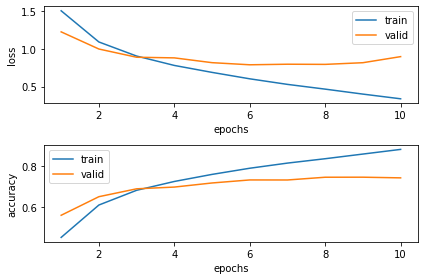

In [20]:
plot_training_curves(train_losses, train_accs, val_losses, val_accs)

In [21]:
true_values, pred_values = evaluate(model_1, test_dl)

print("** accuracy: {:.3f}".format(accuracy_score(true_values, pred_values)))
print("--")
print("confusion matrix")
print(confusion_matrix(true_values, pred_values))
print("--")
print("classification report")
print(classification_report(true_values, pred_values, target_names=CIFAR10_LABELS))

** accuracy: 0.742
--
confusion matrix
[[713   9  53  42  16   9  19  10  95  34]
 [ 14 828   0   8   4   2   9   3  50  82]
 [ 42   4 571  75 101  42  91  35  23  16]
 [ 10   8  47 599  62 104  87  37  25  21]
 [ 10   3  43  72 710  17  62  65  15   3]
 [  8   3  28 195  58 579  40  53  21  15]
 [  6   3  17  53  27  14 859   3  13   5]
 [ 11   6  13  52  43  39  11 813   4   8]
 [ 21  18  10  12   4   3   7   5 905  15]
 [ 29  49   6  15   3   3   9  11  33 842]]
--
classification report
              precision    recall  f1-score   support

    aircraft       0.83      0.71      0.77      1000
  automobile       0.89      0.83      0.86      1000
        bird       0.72      0.57      0.64      1000
         cat       0.53      0.60      0.56      1000
        deer       0.69      0.71      0.70      1000
         dog       0.71      0.58      0.64      1000
        frog       0.72      0.86      0.78      1000
       horse       0.79      0.81      0.80      1000
        ship      

In [22]:
metric_filepath = os.path.join(MODEL_DIR, "model_1.json")
write_metrics(true_values, pred_values, "wider_network", metric_filepath)

### Deeper Network

In [23]:
model_2 = Cifar10Classifier(
    conv_block_sizes=[32, 64, 64], 
    ff_block_sizes=[512, 256])
summary(model_2, (3, 32, 32), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
         Dropout2d-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
              ReLU-6           [-1, 64, 16, 16]               0
         Dropout2d-7           [-1, 64, 16, 16]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Conv2d-9             [-1, 64, 8, 8]          36,928
             ReLU-10             [-1, 64, 8, 8]               0
        Dropout2d-11             [-1, 64, 8, 8]               0
        MaxPool2d-12             [-1, 64, 4, 4]               0
          Flatten-13                 [-1, 1024]               0
           Linear-14                  [

In [24]:
model_2 = model_2.to(dev)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=LEARNING_RATE)

train_losses, train_accs, val_losses, val_accs = [], [], [], []
for epoch in range(1, NUM_EPOCHS + 1):
  train_loss, train_acc = train(model_2, train_dl, loss_fn, optimizer)
  val_loss, val_acc = validate(model_2, test_dl, loss_fn)
  print("Epoch {:2d} | Train Loss: {:.3f}, Accuracy: {:.3f} | Validation Loss: {:.3f}, Accuracy: {:.3f}".format(
      epoch, train_loss, train_acc, val_loss, val_acc))
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  val_losses.append(val_loss)
  val_accs.append(val_acc)

Epoch  1 | Train Loss: 1.552, Accuracy: 0.428 | Validation Loss: 1.248, Accuracy: 0.538
Epoch  2 | Train Loss: 1.108, Accuracy: 0.600 | Validation Loss: 0.992, Accuracy: 0.642
Epoch  3 | Train Loss: 0.907, Accuracy: 0.680 | Validation Loss: 0.933, Accuracy: 0.673
Epoch  4 | Train Loss: 0.771, Accuracy: 0.728 | Validation Loss: 0.885, Accuracy: 0.692
Epoch  5 | Train Loss: 0.669, Accuracy: 0.763 | Validation Loss: 0.820, Accuracy: 0.720
Epoch  6 | Train Loss: 0.584, Accuracy: 0.793 | Validation Loss: 0.803, Accuracy: 0.728
Epoch  7 | Train Loss: 0.507, Accuracy: 0.821 | Validation Loss: 0.775, Accuracy: 0.741
Epoch  8 | Train Loss: 0.436, Accuracy: 0.846 | Validation Loss: 0.859, Accuracy: 0.733
Epoch  9 | Train Loss: 0.364, Accuracy: 0.870 | Validation Loss: 0.944, Accuracy: 0.721
Epoch 10 | Train Loss: 0.301, Accuracy: 0.894 | Validation Loss: 0.951, Accuracy: 0.732


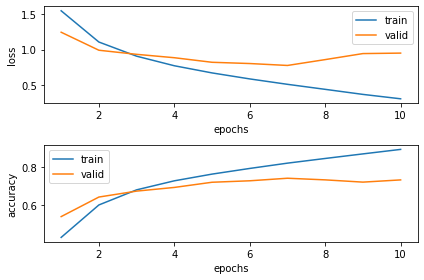

In [25]:
plot_training_curves(train_losses, train_accs, val_losses, val_accs)

In [26]:
true_values, pred_values = evaluate(model_2, test_dl)

print("** accuracy: {:.3f}".format(accuracy_score(true_values, pred_values)))
print("--")
print("confusion matrix")
print(confusion_matrix(true_values, pred_values))
print("--")
print("classification report")
print(classification_report(true_values, pred_values, target_names=CIFAR10_LABELS))

** accuracy: 0.732
--
confusion matrix
[[735  11  69  14  23   8   9  15 102  14]
 [ 16 851  10   6   0   2  13   3  49  50]
 [ 51   2 668  45  73  24  57  51  23   6]
 [ 14   8  86 491  91 112 106  61  16  15]
 [ 14   4  73  43 700  21  49  84  10   2]
 [  9   5  77 156  53 547  49  90  10   4]
 [  4   7  31  39  36  17 840  11  12   3]
 [  7   3  43  28  38  26   6 835   7   7]
 [ 26  17  15   8   9   3   5   4 907   6]
 [ 35 106  13  17   7   5   8  16  47 746]]
--
classification report
              precision    recall  f1-score   support

    aircraft       0.81      0.73      0.77      1000
  automobile       0.84      0.85      0.85      1000
        bird       0.62      0.67      0.64      1000
         cat       0.58      0.49      0.53      1000
        deer       0.68      0.70      0.69      1000
         dog       0.72      0.55      0.62      1000
        frog       0.74      0.84      0.78      1000
       horse       0.71      0.83      0.77      1000
        ship      

In [27]:
metric_filepath = os.path.join(MODEL_DIR, "model_2.json")
write_metrics(true_values, pred_values, "deeper_network", metric_filepath)

### Add Batch Normalization (before ReLU)

There seems to be some controversy about where to put the BatchNorm in the model. According to Andrew Ng, it should be put before the non-linearity but according to Francois Chollet, the authors of the BatchNorm paper put this after the non-linerity. See [Stack Overflow discussion](https://stackoverflow.com/questions/47143521/where-to-apply-batch-normalization-on-standard-cnns#:~:text=Andrew%20Ng%20says%20that%20batch,BN%20after%20the%20activation%20layer.).

We will try both approaches to compare.

In [28]:
class Cifar10ClassifierBNR(nn.Module):
  def __init__(self, conv_block_sizes, ff_block_sizes,
               spatial_dropout=0, dense_dropout=0,
               input_channels=3, input_size=(32, 32), output_size=10):
    super(Cifar10ClassifierBNR, self).__init__()
    # convolution layers
    conv_layers = []
    for cid in range(len(conv_block_sizes)):
      conv_layers.append(nn.Sequential(
        nn.Conv2d(input_channels if cid == 0 else conv_block_sizes[cid - 1],
                  conv_block_sizes[cid], 
                  kernel_size=(3, 3), padding=(1, 1)),
        nn.BatchNorm2d(conv_block_sizes[cid]),
        nn.ReLU(),
        nn.Dropout2d(p=spatial_dropout),
        nn.MaxPool2d(kernel_size=(2, 2))))
    self.conv_blocks = nn.ModuleList(conv_layers)
    # flatten
    self.flatten = nn.Flatten()
    # compute image size to figure out input size after flatten
    conv_output_width = input_size[0] // (2 ** len(conv_block_sizes))
    if conv_output_width < 1:
      raise ValueError("CNN pooling results in less than (1, 1) dimensions, reduce depth")
    conv_size = conv_output_width * conv_output_width * conv_block_sizes[cid]
    # linear layers
    linear_layers = []
    for fid in range(len(ff_block_sizes) + 1):
      linear_layers.append(nn.Sequential(
          nn.Linear(conv_size if fid == 0 else ff_block_sizes[fid - 1],
                    output_size if fid == len(ff_block_sizes) else ff_block_sizes[fid]),
          nn.Dropout(p=dense_dropout),
          nn.ReLU() if fid < len(ff_block_sizes) else nn.LogSoftmax(dim=1)
      ))
    self.linear_blocks = nn.ModuleList(linear_layers)

  def forward(self, x):
    for conv_block in self.conv_blocks:
      x = conv_block(x)
    x = self.flatten(x)
    for linear_block in self.linear_blocks:
      x = linear_block(x)
    return x


model_3 = Cifar10ClassifierBNR(
    conv_block_sizes=[32, 64, 64], 
    ff_block_sizes=[64])
summary(model_3, (3, 32, 32), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
         Dropout2d-4           [-1, 32, 32, 32]               0
         MaxPool2d-5           [-1, 32, 16, 16]               0
            Conv2d-6           [-1, 64, 16, 16]          18,496
       BatchNorm2d-7           [-1, 64, 16, 16]             128
              ReLU-8           [-1, 64, 16, 16]               0
         Dropout2d-9           [-1, 64, 16, 16]               0
        MaxPool2d-10             [-1, 64, 8, 8]               0
           Conv2d-11             [-1, 64, 8, 8]          36,928
      BatchNorm2d-12             [-1, 64, 8, 8]             128
             ReLU-13             [-1, 64, 8, 8]               0
        Dropout2d-14             [-1, 6

In [29]:
model_3 = model_3.to(dev)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=LEARNING_RATE)

train_losses, train_accs, val_losses, val_accs = [], [], [], []
for epoch in range(1, NUM_EPOCHS + 1):
  train_loss, train_acc = train(model_3, train_dl, loss_fn, optimizer)
  val_loss, val_acc = validate(model_3, test_dl, loss_fn)
  print("Epoch {:2d} | Train Loss: {:.3f}, Accuracy: {:.3f} | Validation Loss: {:.3f}, Accuracy: {:.3f}".format(
      epoch, train_loss, train_acc, val_loss, val_acc))
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  val_losses.append(val_loss)
  val_accs.append(val_acc)

Epoch  1 | Train Loss: 1.206, Accuracy: 0.566 | Validation Loss: 0.938, Accuracy: 0.669
Epoch  2 | Train Loss: 0.864, Accuracy: 0.696 | Validation Loss: 1.020, Accuracy: 0.650
Epoch  3 | Train Loss: 0.743, Accuracy: 0.741 | Validation Loss: 0.936, Accuracy: 0.674
Epoch  4 | Train Loss: 0.663, Accuracy: 0.769 | Validation Loss: 0.887, Accuracy: 0.695
Epoch  5 | Train Loss: 0.601, Accuracy: 0.790 | Validation Loss: 0.939, Accuracy: 0.697
Epoch  6 | Train Loss: 0.542, Accuracy: 0.810 | Validation Loss: 0.747, Accuracy: 0.743
Epoch  7 | Train Loss: 0.495, Accuracy: 0.827 | Validation Loss: 0.785, Accuracy: 0.738
Epoch  8 | Train Loss: 0.460, Accuracy: 0.838 | Validation Loss: 0.761, Accuracy: 0.754
Epoch  9 | Train Loss: 0.420, Accuracy: 0.852 | Validation Loss: 0.855, Accuracy: 0.729
Epoch 10 | Train Loss: 0.386, Accuracy: 0.864 | Validation Loss: 0.795, Accuracy: 0.752


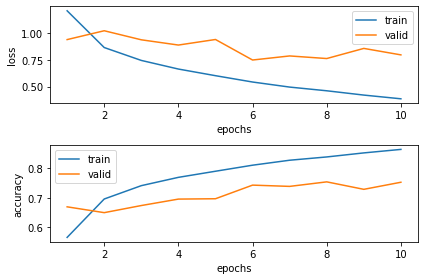

In [30]:
plot_training_curves(train_losses, train_accs, val_losses, val_accs)

In [31]:
true_values, pred_values = evaluate(model_3, test_dl)

print("** accuracy: {:.3f}".format(accuracy_score(true_values, pred_values)))
print("--")
print("confusion matrix")
print(confusion_matrix(true_values, pred_values))
print("--")
print("classification report")
print(classification_report(true_values, pred_values, target_names=CIFAR10_LABELS))

** accuracy: 0.752
--
confusion matrix
[[769  23  38  15   7   2   1   6  76  63]
 [ 11 873   1   3   0   0   2   0   8 102]
 [ 67  14 674  55  46  40  32  25  20  27]
 [ 22  10  49 598  52 125  26  37  33  48]
 [ 26   9  56  69 674  31  21  63  22  29]
 [ 13   9  42 162  19 646  11  52  17  29]
 [  8  11  51  83  36  17 720   4  29  41]
 [ 28   6  28  29  20  37   1 785  12  54]
 [ 40  27   7   5   1   1   0   0 877  42]
 [  8  45   4   7   0   0   2   2  23 909]]
--
classification report
              precision    recall  f1-score   support

    aircraft       0.78      0.77      0.77      1000
  automobile       0.85      0.87      0.86      1000
        bird       0.71      0.67      0.69      1000
         cat       0.58      0.60      0.59      1000
        deer       0.79      0.67      0.73      1000
         dog       0.72      0.65      0.68      1000
        frog       0.88      0.72      0.79      1000
       horse       0.81      0.79      0.80      1000
        ship      

In [32]:
metric_filepath = os.path.join(MODEL_DIR, "model_3.json")
write_metrics(true_values, pred_values, "batchnorm_before_relu", metric_filepath)

### Add Batch Normalization (after ReLU)

In [33]:
class Cifar10ClassifierRBN(nn.Module):
  def __init__(self, conv_block_sizes, ff_block_sizes,
               spatial_dropout=0, dense_dropout=0,
               input_channels=3, input_size=(32, 32), output_size=10):
    super(Cifar10ClassifierRBN, self).__init__()
    # convolution layers
    conv_layers = []
    for cid in range(len(conv_block_sizes)):
      conv_layers.append(nn.Sequential(
        nn.Conv2d(input_channels if cid == 0 else conv_block_sizes[cid - 1],
                  conv_block_sizes[cid], 
                  kernel_size=(3, 3), padding=(1, 1)),
        nn.ReLU(),
        nn.BatchNorm2d(conv_block_sizes[cid]),
        nn.Dropout2d(p=spatial_dropout),
        nn.MaxPool2d(kernel_size=(2, 2))))
    self.conv_blocks = nn.ModuleList(conv_layers)
    # flatten
    self.flatten = nn.Flatten()
    # compute image size to figure out input size after flatten
    conv_output_width = input_size[0] // (2 ** len(conv_block_sizes))
    if conv_output_width < 1:
      raise ValueError("CNN pooling results in less than (1, 1) dimensions, reduce depth")
    conv_size = conv_output_width * conv_output_width * conv_block_sizes[cid]
    # linear layers
    linear_layers = []
    for fid in range(len(ff_block_sizes) + 1):
      linear_layers.append(nn.Sequential(
          nn.Linear(conv_size if fid == 0 else ff_block_sizes[fid - 1],
                    output_size if fid == len(ff_block_sizes) else ff_block_sizes[fid]),
          nn.Dropout(p=dense_dropout),
          nn.ReLU() if fid < len(ff_block_sizes) else nn.LogSoftmax(dim=1)
      ))
    self.linear_blocks = nn.ModuleList(linear_layers)

  def forward(self, x):
    for conv_block in self.conv_blocks:
      x = conv_block(x)
    x = self.flatten(x)
    for linear_block in self.linear_blocks:
      x = linear_block(x)
    return x


model_4 = Cifar10ClassifierRBN(
    conv_block_sizes=[32, 64, 64], 
    ff_block_sizes=[64])
summary(model_4, (3, 32, 32), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
         Dropout2d-4           [-1, 32, 32, 32]               0
         MaxPool2d-5           [-1, 32, 16, 16]               0
            Conv2d-6           [-1, 64, 16, 16]          18,496
              ReLU-7           [-1, 64, 16, 16]               0
       BatchNorm2d-8           [-1, 64, 16, 16]             128
         Dropout2d-9           [-1, 64, 16, 16]               0
        MaxPool2d-10             [-1, 64, 8, 8]               0
           Conv2d-11             [-1, 64, 8, 8]          36,928
             ReLU-12             [-1, 64, 8, 8]               0
      BatchNorm2d-13             [-1, 64, 8, 8]             128
        Dropout2d-14             [-1, 6

In [34]:
model_4 = model_4.to(dev)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_4.parameters(), lr=LEARNING_RATE)

train_losses, train_accs, val_losses, val_accs = [], [], [], []
for epoch in range(1, NUM_EPOCHS + 1):
  train_loss, train_acc = train(model_4, train_dl, loss_fn, optimizer)
  val_loss, val_acc = validate(model_4, test_dl, loss_fn)
  print("Epoch {:2d} | Train Loss: {:.3f}, Accuracy: {:.3f} | Validation Loss: {:.3f}, Accuracy: {:.3f}".format(
      epoch, train_loss, train_acc, val_loss, val_acc))
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  val_losses.append(val_loss)
  val_accs.append(val_acc)

Epoch  1 | Train Loss: 1.118, Accuracy: 0.602 | Validation Loss: 1.047, Accuracy: 0.635
Epoch  2 | Train Loss: 0.772, Accuracy: 0.730 | Validation Loss: 0.848, Accuracy: 0.710
Epoch  3 | Train Loss: 0.634, Accuracy: 0.776 | Validation Loss: 0.742, Accuracy: 0.747
Epoch  4 | Train Loss: 0.538, Accuracy: 0.810 | Validation Loss: 0.797, Accuracy: 0.730
Epoch  5 | Train Loss: 0.463, Accuracy: 0.836 | Validation Loss: 0.761, Accuracy: 0.748
Epoch  6 | Train Loss: 0.400, Accuracy: 0.858 | Validation Loss: 0.922, Accuracy: 0.719
Epoch  7 | Train Loss: 0.338, Accuracy: 0.879 | Validation Loss: 0.797, Accuracy: 0.755
Epoch  8 | Train Loss: 0.289, Accuracy: 0.897 | Validation Loss: 0.923, Accuracy: 0.745
Epoch  9 | Train Loss: 0.248, Accuracy: 0.912 | Validation Loss: 1.010, Accuracy: 0.736
Epoch 10 | Train Loss: 0.219, Accuracy: 0.921 | Validation Loss: 1.023, Accuracy: 0.745


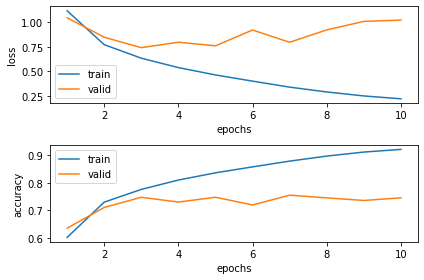

In [35]:
plot_training_curves(train_losses, train_accs, val_losses, val_accs)

In [36]:
true_values, pred_values = evaluate(model_4, test_dl)

print("** accuracy: {:.3f}".format(accuracy_score(true_values, pred_values)))
print("--")
print("confusion matrix")
print(confusion_matrix(true_values, pred_values))
print("--")
print("classification report")
print(classification_report(true_values, pred_values, target_names=CIFAR10_LABELS))

** accuracy: 0.745
--
confusion matrix
[[774  16  26  20   7   3   7  10  69  68]
 [  9 791   2   3   4   3   0   1  24 163]
 [ 76   7 661  82  34  34  36  34  17  19]
 [ 24   6  67 633  34  94  44  40  23  35]
 [ 21   3 103  64 624  23  36  92  19  15]
 [ 15   1  43 233  24 572  24  52  12  24]
 [  6   9  52  63  18  12 807  10  11  12]
 [  8   9  28  50  32  30   4 808   4  27]
 [ 32  14   9  12   2   1   2   0 877  51]
 [ 14  36   3   8   2   2   1   8  19 907]]
--
classification report
              precision    recall  f1-score   support

    aircraft       0.79      0.77      0.78      1000
  automobile       0.89      0.79      0.84      1000
        bird       0.66      0.66      0.66      1000
         cat       0.54      0.63      0.58      1000
        deer       0.80      0.62      0.70      1000
         dog       0.74      0.57      0.64      1000
        frog       0.84      0.81      0.82      1000
       horse       0.77      0.81      0.79      1000
        ship      

In [37]:
metric_filepath = os.path.join(MODEL_DIR, "model_4.json")
write_metrics(true_values, pred_values, "batchnorm_after_relu", metric_filepath)

### Residual Connection

According to [Residual Networks: Implementing ResNets in Pytorch](https://towardsdatascience.com/residual-network-implementing-resnet-a7da63c7b278), a basic ResNet block is composed of two layers of 3x3 conv/batchnorm/relu. Our original model has 3 layers, so we will convert the last two convolution layers into a ResNet block. The shortcut (the "identity" path in the figure below) will pass the input through a 1x1 convolution so the addition `F(x) + x` can be done.

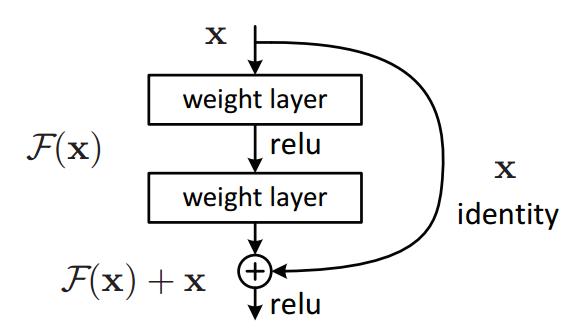

Note that this is just one of the configurations possible with ResNet, other configurations are possible as indicated in [Residual Networks: Building blocks of ResNet](https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec).

In [38]:
class Cifar10ClassifierRes(nn.Module):
  def __init__(self, conv_block_sizes, ff_block_sizes,
               spatial_dropout=0, dense_dropout=0,
               input_channels=3, input_size=(32, 32), output_size=10):
    super(Cifar10ClassifierRes, self).__init__()
    # convolution layers
    conv_layers, shortcuts, poolings = [], [], []
    for cid in range(len(conv_block_sizes)):
      conv_layers.append(nn.Sequential(
        nn.Conv2d(input_channels if cid == 0 else conv_block_sizes[cid - 1],
                  conv_block_sizes[cid], 
                  kernel_size=(3, 3), padding=(1, 1)),
        # batchnorm before relu gives better results
        nn.BatchNorm2d(conv_block_sizes[cid]),
        nn.ReLU(),
        nn.Conv2d(conv_block_sizes[cid], conv_block_sizes[cid],
                  kernel_size=(3, 3), padding=(1, 1)),
        nn.BatchNorm2d(conv_block_sizes[cid]),
        nn.Dropout2d(p=spatial_dropout)))
      shortcuts.append(nn.Sequential(
        nn.Conv2d(input_channels if cid == 0 else conv_block_sizes[cid - 1], 
                  conv_block_sizes[cid], 
                  kernel_size=(1, 1))))
      poolings.append(nn.MaxPool2d(kernel_size=(2, 2)))

    self.conv_blocks = nn.ModuleList(conv_layers)
    self.shortcut_paths = nn.ModuleList(shortcuts)
    self.pool_ops = nn.ModuleList(poolings)

    # flatten
    self.flatten = nn.Flatten()
    # compute image size to figure out input size after flatten
    conv_output_width = input_size[0] // (2 ** len(conv_block_sizes))
    if conv_output_width < 1:
      raise ValueError("CNN pooling results in less than (1, 1) dimensions, reduce depth")
    conv_size = conv_output_width * conv_output_width * conv_block_sizes[cid]
    # linear layers
    linear_layers = []
    for fid in range(len(ff_block_sizes) + 1):
      linear_layers.append(nn.Sequential(
          nn.Linear(conv_size if fid == 0 else ff_block_sizes[fid - 1],
                    output_size if fid == len(ff_block_sizes) else ff_block_sizes[fid]),
          nn.Dropout(p=dense_dropout),
          nn.ReLU() if fid < len(ff_block_sizes) else nn.LogSoftmax(dim=1)
      ))
    self.linear_blocks = nn.ModuleList(linear_layers)

  def forward(self, x):
    for conv_block, shortcut_path, pool_op in zip(
        self.conv_blocks, self.shortcut_paths, self.pool_ops):
      x = conv_block(x) + shortcut_path(x)
      x = F.relu(x)
      x = pool_op(x)
    x = self.flatten(x)
    for linear_block in self.linear_blocks:
      x = linear_block(x)
    return x


model_5 = Cifar10ClassifierRes(
    conv_block_sizes=[32, 64, 64], 
    ff_block_sizes=[64])
summary(model_5, (3, 32, 32), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           9,248
       BatchNorm2d-5           [-1, 32, 32, 32]              64
         Dropout2d-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 32, 32, 32]             128
         MaxPool2d-8           [-1, 32, 16, 16]               0
            Conv2d-9           [-1, 64, 16, 16]          18,496
      BatchNorm2d-10           [-1, 64, 16, 16]             128
             ReLU-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,928
      BatchNorm2d-13           [-1, 64, 16, 16]             128
        Dropout2d-14           [-1, 64,

In [39]:
model_5 = model_5.to(dev)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_5.parameters(), lr=LEARNING_RATE)

train_losses, train_accs, val_losses, val_accs = [], [], [], []
for epoch in range(1, NUM_EPOCHS + 1):
  train_loss, train_acc = train(model_5, train_dl, loss_fn, optimizer)
  val_loss, val_acc = validate(model_5, test_dl, loss_fn)
  print("Epoch {:2d} | Train Loss: {:.3f}, Accuracy: {:.3f} | Validation Loss: {:.3f}, Accuracy: {:.3f}".format(
      epoch, train_loss, train_acc, val_loss, val_acc))
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  val_losses.append(val_loss)
  val_accs.append(val_acc)

Epoch  1 | Train Loss: 1.103, Accuracy: 0.605 | Validation Loss: 1.011, Accuracy: 0.647
Epoch  2 | Train Loss: 0.698, Accuracy: 0.758 | Validation Loss: 0.971, Accuracy: 0.674
Epoch  3 | Train Loss: 0.562, Accuracy: 0.805 | Validation Loss: 0.652, Accuracy: 0.777
Epoch  4 | Train Loss: 0.467, Accuracy: 0.837 | Validation Loss: 0.600, Accuracy: 0.796
Epoch  5 | Train Loss: 0.392, Accuracy: 0.862 | Validation Loss: 0.655, Accuracy: 0.782
Epoch  6 | Train Loss: 0.333, Accuracy: 0.884 | Validation Loss: 0.566, Accuracy: 0.814
Epoch  7 | Train Loss: 0.281, Accuracy: 0.902 | Validation Loss: 0.602, Accuracy: 0.804
Epoch  8 | Train Loss: 0.237, Accuracy: 0.916 | Validation Loss: 0.645, Accuracy: 0.805
Epoch  9 | Train Loss: 0.193, Accuracy: 0.932 | Validation Loss: 0.677, Accuracy: 0.800
Epoch 10 | Train Loss: 0.169, Accuracy: 0.940 | Validation Loss: 0.683, Accuracy: 0.810


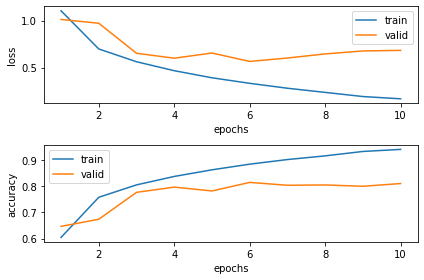

In [40]:
plot_training_curves(train_losses, train_accs, val_losses, val_accs)

In [41]:
true_values, pred_values = evaluate(model_5, test_dl)

print("** accuracy: {:.3f}".format(accuracy_score(true_values, pred_values)))
print("--")
print("confusion matrix")
print(confusion_matrix(true_values, pred_values))
print("--")
print("classification report")
print(classification_report(true_values, pred_values, target_names=CIFAR10_LABELS))

** accuracy: 0.810
--
confusion matrix
[[854  19  35  18   9   3   3   9  32  18]
 [ 14 931   1   2   3   1   3   0  11  34]
 [ 47   3 763  37  44  34  48  15   5   4]
 [ 15   3  58 701  43  88  57  14  12   9]
 [ 13   2  73  53 759  21  40  32   7   0]
 [ 11   1  55 157  38 686  24  23   4   1]
 [  1   4  46  60  14   8 859   2   5   1]
 [ 11   4  25  36  47  36   5 833   1   2]
 [ 47  33   9   9   6   1   3   3 869  20]
 [ 25  81   6   8   1   6   5   5  14 849]]
--
classification report
              precision    recall  f1-score   support

    aircraft       0.82      0.85      0.84      1000
  automobile       0.86      0.93      0.89      1000
        bird       0.71      0.76      0.74      1000
         cat       0.65      0.70      0.67      1000
        deer       0.79      0.76      0.77      1000
         dog       0.78      0.69      0.73      1000
        frog       0.82      0.86      0.84      1000
       horse       0.89      0.83      0.86      1000
        ship      

In [42]:
metric_filepath = os.path.join(MODEL_DIR, "model_5.json")
write_metrics(true_values, pred_values, "residual_conn", metric_filepath)

### Gradient Clipping

More popular in RNNs, and wasn't actually mentioned in the lectures, but I learned about it in passing and was curious to see if it might have an effect on CNNs.

This is achieved in the training loop by clipping the gradients (between `loss.backward()` and `optimizer.step()`.

In [43]:
model_6 = Cifar10Classifier(
    conv_block_sizes=[32, 64, 64], 
    ff_block_sizes=[64])
summary(model_6, (3, 32, 32), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
         Dropout2d-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
              ReLU-6           [-1, 64, 16, 16]               0
         Dropout2d-7           [-1, 64, 16, 16]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Conv2d-9             [-1, 64, 8, 8]          36,928
             ReLU-10             [-1, 64, 8, 8]               0
        Dropout2d-11             [-1, 64, 8, 8]               0
        MaxPool2d-12             [-1, 64, 4, 4]               0
          Flatten-13                 [-1, 1024]               0
           Linear-14                   

In [44]:
def train_with_grad_clipping(model, train_dl, loss_fn, optimizer):
  model.train()
  train_losses, train_accs = [], []
  for batch in train_dl:
    images, labels = batch
    
    images = images.to(dev)
    labels = labels.to(dev)

    logits = model(images)
    loss = loss_fn(logits, labels)
    
    train_losses.append(loss.item())
    preds = torch.argmax(logits, dim=1).cpu().numpy()
    labels = labels.cpu().numpy()
    train_accs.append(accuracy_score(preds, labels))

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    optimizer.zero_grad()

    # if len(train_losses) > 5:
    #   break
  
  train_loss = sum(train_losses) / len(train_losses)
  train_acc = sum(train_accs) / len(train_accs)
  return train_loss, train_acc


# # self-test
# dev = "cpu"
# train_loss, train_acc = train(model_6, train_dl, loss_fn, optimizer)
# train_loss, train_acc

In [45]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_6 = model_6.to(dev)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_6.parameters(), lr=LEARNING_RATE)

train_losses, train_accs, val_losses, val_accs = [], [], [], []
for epoch in range(1, NUM_EPOCHS + 1):
  train_loss, train_acc = train_with_grad_clipping(model_6, train_dl, loss_fn, optimizer)
  val_loss, val_acc = validate(model_6, test_dl, loss_fn)
  print("Epoch {:2d} | Train Loss: {:.3f}, Accuracy: {:.3f} | Validation Loss: {:.3f}, Accuracy: {:.3f}".format(
      epoch, train_loss, train_acc, val_loss, val_acc))
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  val_losses.append(val_loss)
  val_accs.append(val_acc)

Epoch  1 | Train Loss: 1.631, Accuracy: 0.402 | Validation Loss: 1.350, Accuracy: 0.510
Epoch  2 | Train Loss: 1.255, Accuracy: 0.548 | Validation Loss: 1.147, Accuracy: 0.581
Epoch  3 | Train Loss: 1.097, Accuracy: 0.608 | Validation Loss: 1.031, Accuracy: 0.637
Epoch  4 | Train Loss: 0.979, Accuracy: 0.654 | Validation Loss: 1.019, Accuracy: 0.640
Epoch  5 | Train Loss: 0.896, Accuracy: 0.685 | Validation Loss: 0.941, Accuracy: 0.674
Epoch  6 | Train Loss: 0.831, Accuracy: 0.710 | Validation Loss: 0.887, Accuracy: 0.693
Epoch  7 | Train Loss: 0.779, Accuracy: 0.726 | Validation Loss: 0.837, Accuracy: 0.710
Epoch  8 | Train Loss: 0.727, Accuracy: 0.745 | Validation Loss: 0.846, Accuracy: 0.705
Epoch  9 | Train Loss: 0.689, Accuracy: 0.760 | Validation Loss: 0.813, Accuracy: 0.720
Epoch 10 | Train Loss: 0.654, Accuracy: 0.772 | Validation Loss: 0.810, Accuracy: 0.727


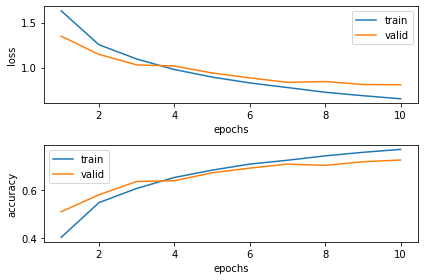

In [46]:
plot_training_curves(train_losses, train_accs, val_losses, val_accs)

In [47]:
true_values, pred_values = evaluate(model_6, test_dl)

print("** accuracy: {:.3f}".format(accuracy_score(true_values, pred_values)))
print("--")
print("confusion matrix")
print(confusion_matrix(true_values, pred_values))
print("--")
print("classification report")
print(classification_report(true_values, pred_values, target_names=CIFAR10_LABELS))

** accuracy: 0.728
--
confusion matrix
[[754  14  56  14  11  10  14  20  53  54]
 [ 14 840   4   7   2   3   7   3  24  96]
 [ 55   3 653  50  42  76  59  42   7  13]
 [ 20   5  74 478  32 241  71  43  17  19]
 [ 18   2 130  75 526  54  77 106  10   2]
 [ 12   2  45  99  22 713  28  64   7   8]
 [  9   2  39  47  11  32 847   4   7   2]
 [ 10   2  26  31  30  73   9 805   5   9]
 [ 66  22  14  10   4   6   5   3 835  35]
 [ 30  59   7  16   2   8  11  21  21 825]]
--
classification report
              precision    recall  f1-score   support

    aircraft       0.76      0.75      0.76      1000
  automobile       0.88      0.84      0.86      1000
        bird       0.62      0.65      0.64      1000
         cat       0.58      0.48      0.52      1000
        deer       0.77      0.53      0.63      1000
         dog       0.59      0.71      0.64      1000
        frog       0.75      0.85      0.80      1000
       horse       0.72      0.81      0.76      1000
        ship      

In [48]:
metric_filepath = os.path.join(MODEL_DIR, "model_6.json")
write_metrics(true_values, pred_values, "gradient_clipping", metric_filepath)

### Increase Batch Size

We will increase the batch size from 64 to 128. This will require us to reinstantiate our data loaders.

In [49]:
BATCH_SIZE = 128

train_dl_128 = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dl_128 = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

len(train_dl_128), len(test_dl_128)

(391, 79)

In [50]:
model_7 = Cifar10Classifier(
    conv_block_sizes=[32, 64, 64], 
    ff_block_sizes=[64])
summary(model_7, (3, 32, 32), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
         Dropout2d-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
              ReLU-6           [-1, 64, 16, 16]               0
         Dropout2d-7           [-1, 64, 16, 16]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Conv2d-9             [-1, 64, 8, 8]          36,928
             ReLU-10             [-1, 64, 8, 8]               0
        Dropout2d-11             [-1, 64, 8, 8]               0
        MaxPool2d-12             [-1, 64, 4, 4]               0
          Flatten-13                 [-1, 1024]               0
           Linear-14                   

In [51]:
model_7 = model_7.to(dev)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_7.parameters(), lr=LEARNING_RATE)

train_losses, train_accs, val_losses, val_accs = [], [], [], []
for epoch in range(1, NUM_EPOCHS + 1):
  train_loss, train_acc = train(model_7, train_dl_128, loss_fn, optimizer)
  val_loss, val_acc = validate(model_7, test_dl_128, loss_fn)
  print("Epoch {:2d} | Train Loss: {:.3f}, Accuracy: {:.3f} | Validation Loss: {:.3f}, Accuracy: {:.3f}".format(
      epoch, train_loss, train_acc, val_loss, val_acc))
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  val_losses.append(val_loss)
  val_accs.append(val_acc)

Epoch  1 | Train Loss: 1.689, Accuracy: 0.383 | Validation Loss: 1.455, Accuracy: 0.476
Epoch  2 | Train Loss: 1.336, Accuracy: 0.519 | Validation Loss: 1.266, Accuracy: 0.540
Epoch  3 | Train Loss: 1.165, Accuracy: 0.587 | Validation Loss: 1.140, Accuracy: 0.595
Epoch  4 | Train Loss: 1.051, Accuracy: 0.629 | Validation Loss: 1.040, Accuracy: 0.633
Epoch  5 | Train Loss: 0.969, Accuracy: 0.659 | Validation Loss: 0.980, Accuracy: 0.649
Epoch  6 | Train Loss: 0.904, Accuracy: 0.684 | Validation Loss: 0.927, Accuracy: 0.670
Epoch  7 | Train Loss: 0.850, Accuracy: 0.703 | Validation Loss: 0.901, Accuracy: 0.687
Epoch  8 | Train Loss: 0.805, Accuracy: 0.720 | Validation Loss: 0.876, Accuracy: 0.695
Epoch  9 | Train Loss: 0.758, Accuracy: 0.734 | Validation Loss: 0.846, Accuracy: 0.706
Epoch 10 | Train Loss: 0.731, Accuracy: 0.746 | Validation Loss: 0.863, Accuracy: 0.707


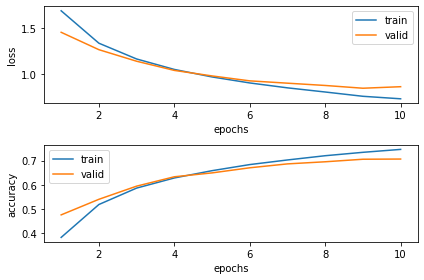

In [52]:
plot_training_curves(train_losses, train_accs, val_losses, val_accs)

In [53]:
true_values, pred_values = evaluate(model_7, test_dl)

print("** accuracy: {:.3f}".format(accuracy_score(true_values, pred_values)))
print("--")
print("confusion matrix")
print(confusion_matrix(true_values, pred_values))
print("--")
print("classification report")
print(classification_report(true_values, pred_values, target_names=CIFAR10_LABELS))

** accuracy: 0.707
--
confusion matrix
[[754  16  65  31  12   6  21  12  52  31]
 [ 27 807   9  14   1  12  20   1  19  90]
 [ 53   2 624  63  47  58 115  25   8   5]
 [ 18   4  67 532  46 171 122  19   6  15]
 [ 21   4  87  76 560  49 123  66  12   2]
 [ 13   2  58 171  37 621  58  34   3   3]
 [  6   0  29  39   7  15 895   3   4   2]
 [ 13   2  38  55  52  88  19 717   3  13]
 [ 67  28  24  24   6  11  23   2 797  18]
 [ 34  80   9  35   7  16  21  12  25 761]]
--
classification report
              precision    recall  f1-score   support

    aircraft       0.75      0.75      0.75      1000
  automobile       0.85      0.81      0.83      1000
        bird       0.62      0.62      0.62      1000
         cat       0.51      0.53      0.52      1000
        deer       0.72      0.56      0.63      1000
         dog       0.59      0.62      0.61      1000
        frog       0.63      0.90      0.74      1000
       horse       0.80      0.72      0.76      1000
        ship      

In [54]:
metric_filepath = os.path.join(MODEL_DIR, "model_7.json")
write_metrics(true_values, pred_values, "inc_batch_size", metric_filepath)

## Model Comparison

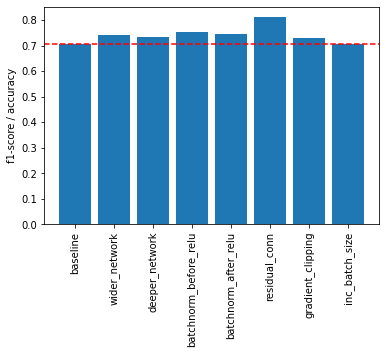

In [55]:
json_files = []
for f in os.listdir(MODEL_DIR):
  if f.endswith(".json"):
    json_files.append(f)

xs, ps, rs, fs = [], [], [], []
for json_file in sorted(json_files):
  with open(os.path.join(MODEL_DIR, json_file), "r") as f:
    metrics_dict = json.loads(f.read())
    xs.append(metrics_dict["name"])
    ps.append(metrics_dict["precision"])
    rs.append(metrics_dict["recall"])
    fs.append(metrics_dict["f1-score"])

plt.bar(np.arange(len(fs)), fs)
plt.ylabel("f1-score / accuracy")
plt.xticks(np.arange(len(fs)), xs, rotation="90")
plt.axhline(fs[0], 0, len(fs), color="r", linestyle="--")
_ = plt.show()

In [57]:
list_of_dicts = []
for json_file in os.listdir(MODEL_DIR):
  if json_file.endswith(".json"):
    with open(os.path.join(MODEL_DIR, json_file), "r") as f:
      list_of_dicts.append(json.loads(f.read()))

results_df = pd.DataFrame(list_of_dicts)
results_df = results_df.sort_values("f1-score", axis=0, ascending=False)
results_df.head(len(list_of_dicts))

,precision,recall,f1-score,support,name
5,0.8104,0.8104,0.8104,None,residual_conn
1,0.7525,0.7525,0.7525,None,batchnorm_before_relu
3,0.7454,0.7454,0.7454,None,batchnorm_after_relu
6,0.7419,0.7419,0.7419,None,wider_network
4,0.7320,0.7320,0.7320,None,deeper_network
0,0.7276,0.7276,0.7276,None,gradient_clipping
7,0.7068,0.7068,0.7068,None,inc_batch_size
2,0.7045,0.7045,0.7045,None,baseline
